# AI Observer - Full model

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.tabular import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.metrics import error_rate
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import pickle as pkl
import copy
torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='GeForce RTX 2060', major=7, minor=5, total_memory=5926MB, multi_processor_count=30)

## Species

### Tabular

In [3]:
def add_datepart(df, fldname, drop=True, time=False):
    "Helper function that adds columns relevant to a date."
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [4]:
path = Path("/home/alan/Desktop/personal_professional/fastai/mushroom_classifier")

In [22]:
df_4 = pd.read_csv(path / "resources/ds4_100mostPopSpecies.csv")
add_datepart(df_4, "when")
procs = [FillMissing, Categorify, Normalize]
cat_vars = ['where', 'is_collection_location',
            'whenYear', 'whenMonth', 'whenWeek',
            'whenDay', 'whenDayofyear', 'whenIs_month_end',
            'whenDayofweek',
            'whenIs_month_start', 'whenIs_quarter_end', 'whenIs_quarter_start',
            'whenIs_year_end', 'whenIs_year_start', 'whenElapsed']
cont_vars = ['lat', 'long', 'alt', 'north', 'south', 'east', 'west', 'high', 'low']
ilt4 = TabularList.from_df(df_4, path=path / "resources", cat_names=cat_vars, cont_names=cont_vars,
                           procs=procs)

### Vision

In [23]:
ds_tfms = get_transforms(flip_vert=True, max_rotate=45.)
ilv4 = ImageList.from_csv(path / "images/320", "../../resources/ds4_100mostPopSpecies.csv",
                          cols="image_id", suffix='.jpg')

### Combined item list

In [24]:
il4 = (MixedItemList([ilt4, ilv4], path=path, inner_df=ilv4.inner_df)
       .split_from_df("is_validation")
       .label_from_df("preferred_name")
       .transform(tfms=[[[], ds_tfms[0]], [[], ds_tfms[1]]], size=300)
      )

### Special functions

In [25]:
def _normalize_images_batch(b:Tuple[Tensor,Tensor], mean:FloatTensor, std:FloatTensor)->Tuple[Tensor,Tensor]:
    "`b` = `x`,`y` - normalize `x` array of imgs and `do_y` optionally `y`."
    x,y = b
    mean,std = mean.to(x[1].device),std.to(x[1].device)
    x[1] = normalize(x[1],mean,std)
    return x,y

def normalize_custom_funcs(mean:FloatTensor, std:FloatTensor, do_x:bool=True, do_y:bool=False)->Tuple[Callable,Callable]:
    "Create normalize/denormalize func using `mean` and `std`, can specify `do_y` and `device`."
    mean,std = tensor(mean),tensor(std)
    return (partial(_normalize_images_batch, mean=mean, std=std),
            partial(denormalize, mean=mean, std=std))

### Data bunch

In [26]:
bs = 16
data = il4.databunch(bs=bs, collate_fn=data_collate)
norm, denorm = normalize_custom_funcs(*imagenet_stats)
data.add_tfm(norm) # normalize images

### Model

In [27]:
data_v4 = (ImageList.from_csv(path / "images/320",
                          "../../resources/ds4_100mostPopSpecies.csv", cols="image_id",
                          suffix='.jpg')
        .split_from_df("is_validation")
        .label_from_df("preferred_name")
        .transform(tfms=ds_tfms, size=300)
        .databunch(bs=bs)
        .normalize(imagenet_stats))
learn_v4 = cnn_learner(data_v4, models.resnet34)
learn_v4.load("../../../resources/models/resnet34_ds4_100topSpecies_obsSplit_img")

Learner(data=ImageDataBunch;

Train: LabelList (89268 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Amanita calyptroderma,Amanita calyptroderma,Amanita calyptroderma,Amanita calyptroderma,Leotia viscosa
Path: /home/alan/Desktop/personal_professional/fastai/mushroom_classifier/images/320;

Valid: LabelList (22473 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Tylopilus felleus,Tylopilus felleus,Galerina marginata,Galerina marginata,Galerina marginata
Path: /home/alan/Desktop/personal_professional/fastai/mushroom_classifier/images/320;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_si

In [29]:
data_t4 = (TabularList.from_df(df_4, path=path / "resources", cat_names=cat_vars, cont_names=cont_vars, procs=procs,)
        .split_from_df("is_validation")
        .label_from_df("preferred_name")
        .databunch())

learn_t4 = tabular_learner(data_t4, layers=[512,256], ps=[0.7,0.7], emb_drop=0.7, wd=0.1,
                           metrics=[accuracy, top_k_accuracy])

learn_t4.load("tabular_4_100topSpecies")
learn_t4.model.layers = learn_t4.model.layers[:-3]

In [37]:
class ImageTabularModel(nn.Module):
    def __init__(self, emb_szs:ListSizes, n_cont:int):
        super().__init__()
        #self.cnn = create_body(models.resnet18)
        self.cnn = copy.deepcopy(learn_v4.model)[0]
        nf = num_features_model(self.cnn) * 2
        drop = .25
        tf = 256
        cats = 100

#         self.tab = TabularModel(emb_szs, n_cont, tf, [], ps=[], emb_drop=0.5)
        self.tab = copy.deepcopy(learn_t4.model)

        self.reduce = nn.Sequential(*([AdaptiveConcatPool2d(), Flatten()]
                                      + bn_drop_lin(nf, 512, bn=True, p=drop,
                                                    actn=nn.ReLU(inplace=True))))
        self.merge = nn.Sequential(*bn_drop_lin(512 + tf, 512 + tf, bn=True, p=drop, actn=nn.ReLU(inplace=True)))
        self.final = nn.Sequential(*bn_drop_lin(512 + tf, cats, bn=False, p=0., actn=None))

    def forward(self, x:Tensor, img:Tensor) -> Tensor:
        imgCnn = self.cnn(img)
        imgLatent = self.reduce(imgCnn)
        tabLatent = self.tab(x[0], x[1])

        cat = torch.cat([imgLatent, F.relu(tabLatent)], dim=1)

        return self.final(self.merge(cat))

    @property
    def split_layers(model:nn.Module) -> List[nn.Module]:
        groups = [[model.cnn], [model.tab]] # model.cnn[6]
        groups += [[model.reduce, model.merge, model.final]]
        return groups

In [38]:
class ImageTabularLearner(Learner):
    def __init__(self, data:DataBunch, model:nn.Module, **learn_kwargs):
        super().__init__(data, model, loss_func=nn.CrossEntropyLoss(), **learn_kwargs)
        self.split(model.split_layers)

In [39]:
def image_tabular_learner(data, len_cont_names):
    emb = data.train_ds.x.item_lists[0].get_emb_szs()
    model = ImageTabularModel(emb, len_cont_names)

    learn = ImageTabularLearner(data, model, metrics=[accuracy, top_k_accuracy])
    return learn

In [40]:
learn = image_tabular_learner(data, len(cont_vars))

In [41]:
learn.model

ImageTabularModel(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [42]:
learn.freeze_to(-1)

In [43]:
for p in learn.model.parameters():
    print(p.requires_grad, p.shape)

False torch.Size([64, 3, 7, 7])
False torch.Size([64])
False torch.Size([64])
False torch.Size([64, 64, 3, 3])
False torch.Size([64])
False torch.Size([64])
False torch.Size([64, 64, 3, 3])
False torch.Size([64])
False torch.Size([64])
False torch.Size([64, 64, 3, 3])
False torch.Size([64])
False torch.Size([64])
False torch.Size([64, 64, 3, 3])
False torch.Size([64])
False torch.Size([64])
False torch.Size([64, 64, 3, 3])
False torch.Size([64])
False torch.Size([64])
False torch.Size([64, 64, 3, 3])
False torch.Size([64])
False torch.Size([64])
False torch.Size([128, 64, 3, 3])
False torch.Size([128])
False torch.Size([128])
False torch.Size([128, 128, 3, 3])
False torch.Size([128])
False torch.Size([128])
False torch.Size([128, 64, 1, 1])
False torch.Size([128])
False torch.Size([128])
False torch.Size([128, 128, 3, 3])
False torch.Size([128])
False torch.Size([128])
False torch.Size([128, 128, 3, 3])
False torch.Size([128])
False torch.Size([128])
False torch.Size([128, 128, 3, 3])


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.02E-01
Min loss divided by 10: 6.31E-04


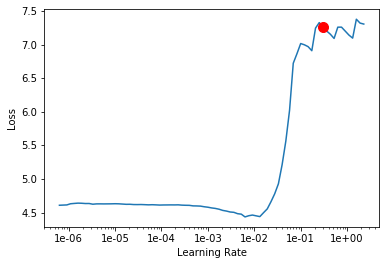

In [44]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [45]:
learn.fit_one_cycle(1, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.204135,1.252815,0.671739,0.886174,06:40


In [46]:
learn.save("full_4_100topSpecies_stage1")

In [121]:
learn.load("full_4_min10obs_stage1")

ImageTabularLearner(data=DataBunch;

Train: LabelList (516972 items)
x: MixedItemList
MixedItem
TabularLine where Cameron Co., Pennsylvania, USA; is_collection_location 1; whenYear 2011; whenMonth 9; whenWeek 39; whenDay 26; whenDayofweek 0; whenDayofyear 269; whenIs_month_end False; whenDayofweek 0; whenIs_month_end False; whenIs_month_start False; whenIs_quarter_end False; whenIs_quarter_start False; whenIs_year_end False; whenIs_year_start False; whenElapsed 1316995200; lat_na True; long_na True; alt_na True; high_na True; low_na True; lat 0.0755; long -0.0712; alt -0.1247; north 0.2586; south 0.2564; east 0.0369; west 0.0540; high -0.1648; low -0.1334; 
Image (3, 300, 300),MixedItem
TabularLine where Cahuacán, Mexico, Mexico; is_collection_location 1; whenYear 2017; whenMonth 7; whenWeek 27; whenDay 9; whenDayofweek 6; whenDayofyear 190; whenIs_month_end False; whenDayofweek 6; whenIs_month_end False; whenIs_month_start False; whenIs_quarter_end False; whenIs_quarter_start False; w

In [47]:
learn.freeze_to(-2)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.94E-08
Min loss divided by 10: 2.00E-09


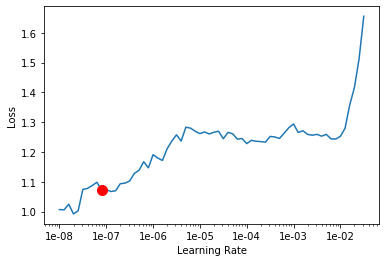

In [48]:
learn.lr_find(start_lr=1e-9)
learn.recorder.plot(suggestion=True)

In [49]:
learn.fit_one_cycle(1, max_lr=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.123021,1.206017,0.685044,0.891158,07:52


In [50]:
learn.freeze_to(-3)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.00E-08
Min loss divided by 10: 6.31E-09


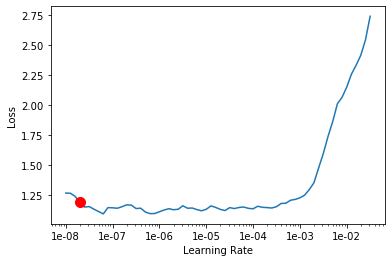

In [51]:
learn.lr_find(start_lr=1e-9)
learn.recorder.plot(suggestion=True)

In [52]:
learn.fit_one_cycle(5, max_lr=slice(1e-7, 1e-6, 1e-5))

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.150622,1.211015,0.684065,0.892004,18:06
1,1.006947,1.203811,0.683843,0.891025,20:00
2,1.033818,1.195563,0.686691,0.892805,20:22
3,1.079693,1.190798,0.685845,0.891559,19:37
4,1.096134,1.196646,0.687358,0.892271,19:40


In [129]:
learn.save("full_4_min10obs_unfreezed")